Time Series Data Imputation with GANs
=============

By Sohaib Errabii, Mael Lucas

Introduction
------------

This notebook is devoted to the investigation of different GAN based methods for time series imputation.


In [2]:
import random
import pandas as pd
import numpy as np
import os
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import UCIHARDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

In [10]:
# Root directory of datasets
root = "data"

# Rate of the missing data
miss_rate = 0.2

# Number of workers for dataloader
workers = 2

# Hidden size of GRU
hz = 64

# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.001

Data
----

We will use the **UCI-HAR** Dataset <https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones>. 



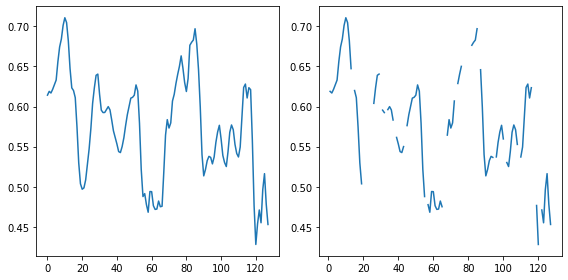

In [4]:
# Create the datasets
ucihar = UCIHARDataset(root_dir=root, download=True)
ucihar_miss = UCIHARDataset(root_dir=root, miss_rate=miss_rate)

# Create the dataloader
dataloader = DataLoader(ucihar_miss, batch_size=batch_size, num_workers=workers)

# Define UCI-HAR parameters
n_samples = len(ucihar)
time_steps = ucihar.data.shape[1]
n_features = len(ucihar.signal_types)


# Plot some signal before/after amputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ucihar.data[sample_id, :, signal_id])
axes[1].plot(ucihar_miss.data[sample_id, :, signal_id])
fig.tight_layout()

# TODO: improve data missingness simulation (something more sequential but controllable with miss_rate)

Model
--------------

We start with a simple GAN model, where the generator and discriminator are instances of `GRUBase`

In [12]:
class GRUBase(nn.Module):
    def __init__(self, sequence_length, input_size, hidden_size):
        super().__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc_out = nn.Sequential(
            nn.ReLU(True),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x, hidden):
        output, _ = self.gru(x, hidden)
        return self.fc_out(output)
    
    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

In [15]:
# Generator & Discriminator
netG = GRUBase(time_steps, n_features, hz)
netD = GRUBase(time_steps, n_features, hz)

# Loss functions
criterionG = lambda data, dataG, mask, probD, alpha: \
    alpha * nn.MSELoss()(mask * data, ~mask * dataG) \
    - torch.mean(~mask * torch.log(torch.add(probD, 1e-8)))
criterionD = nn.BCELoss()

# Optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)

Training
--------------

In [16]:
# Training Loop

# Hyperparameters
alpha = 100

# Lists to keep track of progress
lossesG = []
lossesD = []

for epoch in tqdm(range(num_epochs)):    
    for i, (data, _) in enumerate(dataloader):
        # Sample random noise
        z = torch.rand(data.shape) * 0.01
        
        # Get binary mask from data, mask = 1 if observed
        mask = ~torch.isnan(data)
        
        # Combine random noise with observed data
        data = mask * torch.nan_to_num(data) + ~mask * z
        
        ###################################
        # (1) Update D: minimize criterionD
        ###################################
        netD.zero_grad()
        
        # Generate imputed data with G
        dataG = netG(data, netG.initHidden(data.shape[0]))
        
        # Classify imputed data with D
        data_imp = mask * data + ~mask * dataG
        probD = netD(data_imp.detach(), netD.initHidden(data.shape[0]))
        
        # Compute loss for D
        lossD = criterionD(probD, mask.float())
        # Compute gradients for D
        lossD.backward()
        p_1 = probD.mean().item()
        # Update D
        optimizerD.step()
        
        ###################################
        # (2) Update G: minimize criterionG
        ###################################
        netG.zero_grad()
        
        # Classify imputed data once more since D got updated
        probD = netD(data_imp, netD.initHidden(data.shape[0]))
                
        # Compute loss for G
        lossG = criterionG(data, dataG, mask, probD, alpha)
        # Compute gradients for G
        lossG.backward()
        p_2 = probD.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLossD: %.4f\tLossG: %.4f\tP: %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD.item(), lossG.item(), p_1, p_2))

        # Save Losses for plotting later
        lossesG.append(lossG.item())
        lossesD.append(lossD.item())

  0%|          | 0/20 [00:00<?, ?it/s]

[0/20][0/58]	LossD: 0.7107	LossG: 29.5779	P: 0.4866 / 0.4892
[0/20][50/58]	LossD: 0.5049	LossG: 22.5661	P: 0.8036 / 0.8037


  5%|▌         | 1/20 [00:12<03:51, 12.20s/it]

[1/20][0/58]	LossD: 0.5000	LossG: 24.6635	P: 0.8010 / 0.8003
[1/20][50/58]	LossD: 0.4982	LossG: 22.3686	P: 0.7972 / 0.7970


 10%|█         | 2/20 [00:24<03:36, 12.05s/it]

[2/20][0/58]	LossD: 0.4961	LossG: 24.5408	P: 0.7965 / 0.7963
[2/20][50/58]	LossD: 0.4917	LossG: 22.3402	P: 0.7959 / 0.7959


 15%|█▌        | 3/20 [00:36<03:25, 12.09s/it]

[3/20][0/58]	LossD: 0.4887	LossG: 24.5165	P: 0.7969 / 0.7968
[3/20][50/58]	LossD: 0.4796	LossG: 22.3287	P: 0.7958 / 0.7959


 20%|██        | 4/20 [00:48<03:12, 12.02s/it]

[4/20][0/58]	LossD: 0.4752	LossG: 24.5065	P: 0.7977 / 0.7976
[4/20][50/58]	LossD: 0.4592	LossG: 22.3252	P: 0.7960 / 0.7964


 25%|██▌       | 5/20 [01:00<02:59, 11.99s/it]

[5/20][0/58]	LossD: 0.4530	LossG: 24.5040	P: 0.7990 / 0.7989
[5/20][50/58]	LossD: 0.4289	LossG: 22.3284	P: 0.7948 / 0.7964


 30%|███       | 6/20 [01:12<02:47, 11.97s/it]

[6/20][0/58]	LossD: 0.4207	LossG: 24.5090	P: 0.7969 / 0.7971
[6/20][50/58]	LossD: 0.3909	LossG: 22.3367	P: 0.7963 / 0.7985


 35%|███▌      | 7/20 [01:24<02:35, 11.99s/it]

[7/20][0/58]	LossD: 0.3815	LossG: 24.5187	P: 0.7980 / 0.7983
[7/20][50/58]	LossD: 0.3485	LossG: 22.3494	P: 0.7979 / 0.8014


 40%|████      | 8/20 [01:36<02:25, 12.09s/it]

[8/20][0/58]	LossD: 0.3383	LossG: 24.5337	P: 0.7979 / 0.7987
[8/20][50/58]	LossD: 0.3034	LossG: 22.3670	P: 0.8003 / 0.8039


 45%|████▌     | 9/20 [01:48<02:12, 12.04s/it]

[9/20][0/58]	LossD: 0.2932	LossG: 24.5533	P: 0.7985 / 0.8004
[9/20][50/58]	LossD: 0.2596	LossG: 22.3901	P: 0.8000 / 0.8038


 50%|█████     | 10/20 [02:00<02:00, 12.03s/it]

[10/20][0/58]	LossD: 0.2502	LossG: 24.5780	P: 0.7980 / 0.8002
[10/20][50/58]	LossD: 0.2211	LossG: 22.4164	P: 0.7991 / 0.8036


 55%|█████▌    | 11/20 [02:12<01:48, 12.01s/it]

[11/20][0/58]	LossD: 0.2130	LossG: 24.6067	P: 0.7970 / 0.7986
[11/20][50/58]	LossD: 0.1896	LossG: 22.4447	P: 0.7981 / 0.8024


 60%|██████    | 12/20 [02:24<01:35, 11.97s/it]

[12/20][0/58]	LossD: 0.1821	LossG: 24.6361	P: 0.7974 / 0.7979
[12/20][50/58]	LossD: 0.1642	LossG: 22.4729	P: 0.7974 / 0.8012


 65%|██████▌   | 13/20 [02:36<01:23, 11.98s/it]

[13/20][0/58]	LossD: 0.1570	LossG: 24.6647	P: 0.7984 / 0.7983
[13/20][50/58]	LossD: 0.1435	LossG: 22.4988	P: 0.7980 / 0.8013


 70%|███████   | 14/20 [02:48<01:11, 11.97s/it]

[14/20][0/58]	LossD: 0.1363	LossG: 24.6939	P: 0.7986 / 0.7985
[14/20][50/58]	LossD: 0.1265	LossG: 22.5282	P: 0.7962 / 0.7990


 75%|███████▌  | 15/20 [03:01<01:02, 12.40s/it]

[15/20][0/58]	LossD: 0.1189	LossG: 24.7243	P: 0.7984 / 0.7980
[15/20][50/58]	LossD: 0.1129	LossG: 22.5556	P: 0.7948 / 0.7978


 80%|████████  | 16/20 [03:14<00:50, 12.68s/it]

[16/20][0/58]	LossD: 0.1052	LossG: 24.7512	P: 0.7991 / 0.7985
[16/20][50/58]	LossD: 0.1020	LossG: 22.5803	P: 0.7944 / 0.7973


 85%|████████▌ | 17/20 [03:28<00:39, 13.03s/it]

[17/20][0/58]	LossD: 0.0942	LossG: 24.7760	P: 0.7998 / 0.7990
[17/20][50/58]	LossD: 0.0932	LossG: 22.6039	P: 0.7940 / 0.7968


 90%|█████████ | 18/20 [03:41<00:25, 12.95s/it]

[18/20][0/58]	LossD: 0.0853	LossG: 24.7987	P: 0.8005 / 0.7995
[18/20][50/58]	LossD: 0.0859	LossG: 22.6267	P: 0.7935 / 0.7963


 95%|█████████▌| 19/20 [03:53<00:12, 12.70s/it]

[19/20][0/58]	LossD: 0.0778	LossG: 24.8198	P: 0.8011 / 0.8000
[19/20][50/58]	LossD: 0.0797	LossG: 22.6484	P: 0.7932 / 0.7958


100%|██████████| 20/20 [04:05<00:00, 12.30s/it]
